In [62]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.optimize import root
from scipy.stats import linregress
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import voltage_discrete as vd 
import utils





# this is equialent of C++ bind 
#
def partial(func, *args, **kwargs):
    def f(*args_rest, **kwargs_rest):
        kw = kwargs.copy()
        kw.update(kwargs_rest)
        return func(*(args + args_rest), **kw) 
    return f


# we use this to convert discrete domains into
# continous functions using the partial defined above
# tt is the time domain array of the function 
# vv is the corresponding range array of the function 
# t  is the point were we are interpolating 
#
def interpolator(tt,vv,t):
    return np.interp(t,tt,vv)


# takes a func(t) defined over a domain period 
# and makes it periodic with regards to t
#
def make_periodic(func,period,t):
    return func(t-(t//period)*period)


class TransistorModel:
    
    # 
    # public interface 
    #

    # constructor
    #
    def __init__(self, Cion, Rion):
        
        self.Cion=Cion
        self.Rion=Rion
        
    # single transistor model
    # the tt defines the domain on which 
    # to evaluate the vfunc
    #
    def apply_1T_model(self,Qstart,v0,tt,vfunc):

        v_array=np.array([vfunc(t) for t in tt])
        q_swipe=self.evolve_charge_alt(Qstart,tt,vfunc)

        return (self.j1_1t(q_swipe/self.Cion,v_array),v_array,q_swipe)     
    
    
    #
    # private
    #


    # defines a differential equation for the 
    # evolution of change vs applied voltage over time 
    #
    # returns a difference term for a point in time
    def memdiode(self,q,t,vfunc):
        R = self.Rion
        C = self.Cion

        dqdt = (vfunc(t) - 2*q/C)/R

        return dqdt
    
    
    def evolve_charge(self,Qstart,tt,vfunc):

        # solve and reshape the result to an array from a 1D vector
        q=odeint(self.memdiode,Qstart,tt,args=(vfunc,),hmax=1e-12)
        q=q.reshape(len(tt))

        return q    
    
    
    def memdiode_alt(self,t,q,vfunc):
        return self.memdiode(q,t,vfunc)
    
    def evolve_charge_alt(self,Qstart,tt,vfunc):
        
        # step size
        dt = tt[1]-tt[0]
        
        q0 = [Qstart, 0]
        r = ode(self.memdiode_alt).set_integrator('dop853', method='bdf') 
        r.set_initial_value(q0, tt[0]).set_f_params(vfunc)

        # array for outputs
        qout = np.zeros((len(tt), len(q0)))
        
        tfin = tt[len(tt)-1]
        i=0
        while r.successful() and r.t < tfin:
            qout[i, :] = r.integrate(r.t+dt)
            i=i+1
                    
        q=qout[:,0]
        q=q.reshape(len(tt))
        
        return q
    

    # C=Q/V
    #
    # V=Q/C
    #
    # V kg·m2·s−3·A−1   (or J/C)
    #
    # single transistor model 
    #
    def j1_1t(self,Vc,V):

        v1=V-Vc
        
        j = self.js1 * ( np.exp((self.e*v1)/(self.m1*self.kb*self.T),dtype=np.float64) - \
                         np.exp((self.e*(v1-V))/(self.m1*self.kb*self.T),dtype=np.float64) ) - \
                         self.jphoto

        return j  

    
    
    
    
    # two transistor model
    # the tt defines the domain on which 
    # to evaluate the vfunc
    #
    def apply_2T_model(self,Qstart,v0,tt,vfunc):

        v_array=np.array([vfunc(t) for t in tt])
        q_swipe=self.evolve_charge_alt(Qstart,tt,vfunc)

        (v,j)=self.solve_for_j(q_swipe,v_array,self.jphoto,self.Cion,v0)

        return (j,v,q_swipe)     
     



    ###################################################################
    #
    # two transistor model
    # 

    # C=Q/V
    #
    # V=Q/C
    #
    # V kg·m2·s−3·A−1   (or J/C)
    #
    # two transistor transistor model 
    #
    def j1_2t(self,Vn,v1,V):
                
        j = self.js1 * ( np.exp((self.e*(v1-Vn))/(self.m1*self.kb*self.T),dtype=np.float64) - \
                         np.exp((self.e*(v1-V))/(self.m1*self.kb*self.T),dtype=np.float64) )

        return j

    # C=Q/V
    #
    # V=Q/C
    #
    # V kg·m2·s−3·A−1   (or J/C)
    #
    # two transistor transistor model 
    #
    def j2_2t(self,Vn,v2,V):
                
        j = self.js2 * ( np.exp((self.e*v2)/(self.m1*self.kb*self.T),dtype=np.float64) - \
                         np.exp((self.e*(v2-Vn))/(self.m1*self.kb*self.T),dtype=np.float64) )

        return j

    # j2-j1-jphoto=0
    #
    def kirchoff(self,Vn,v1,v2,V,jphoto):
        return self.j2_2t(Vn,v2,V)-self.j1_2t(Vn,v1,V)+jphoto

    # j is equivalent to simply j2
    # first, we need to solve: j2=j1+jphoto for the unknown Vn
    # then substitue Vn into expression for j2
    #
    def solve_for_j(self,q,V,jphoto,C,v0):

        timesteps=q.size
        
        # q array stores charges on the caps (q same accross all caps)
        # V array has input voltages corresponding to charges above 

        v2=q/C
        v1=V-q/C       
        
        v_n=np.array([root(self.kirchoff,x0=v0,args=(v1[i],v2[i],V[i],jphoto)).x 
                           for i in range(timesteps)]) 
        
        v_n=v_n.reshape(timesteps);
        
        j_array=self.j2_2t(v_n,v2,V) 
            
        return (v_n,j_array)

    
    
    
    
    
    
    

    ###################################################################
    # constants 

    e   = 1.60217662e-19 # A * s
    kb  = 1.38064852e-23 # J/K
        
    # physical parameters
        
    mss=1.93
    fc=0.7
    m1=mss*(1-fc/2)

    js1 = 6.1e-10        # A/m  -10
    js2 = 6.1e-7        # A/m    used to be -7  , -3 gave us the flat Vn on 0
    jphoto=0.          # our generation photo current
    T=300


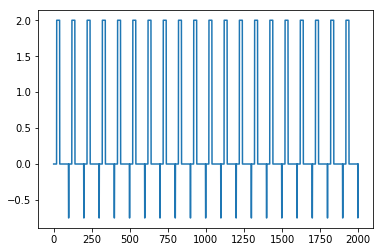

In [81]:
def voltage_lin_sweep(Vi,s,t):
    return (Vi + s*t)

def voltage_bidirectional_sweep(Vi,s,switch_time,t):
    if(t>=switch_time):
        ret = (Vi + s*switch_time) - s*(t-switch_time)
    else:
        ret = (Vi + s*t)
    return ret

# this function, when used in the context of odeint 
# is not a vector function, t is simply a scalar
#
def voltage_pulse(Vmin,Vmax,fr,to,t):
    if( t >= fr and t<to ):
        return Vmax
    else:
        return Vmin
    
# these are our discrete ranges 
# we need to specify both range and value axes 

pulse_t=[0,0.2,0.20001,0.3,0.30001,0.5]
pulse_v=[0,0,2,2,0,0]

double_pulse_t=[0,0.1,0.10001,0.2,0.20001,0.3,0.30001,0.4,0.40001,0.5]
double_pulse_v=[0,0,2,2,0,0,2,2,0,0]
    
double_pulse_pos_neg_v=[0,0,2,2,0,0,-2,-2,0,0]

# here we have the self adjusting definitions for sweeps 
# we can vary number of timeseps (resolution)
# the range 
# and the vale range 

timesteps=2000
time=.5
v_range=.5 # full range (from - to +, e.g. -1 -> 1 : range is 2)
time_domain=np.linspace(0,time,timesteps,dtype=np.float64)
scan_rate=2*v_range/time

# here we have the voltage profiles specified as analytical functions 

vls    = partial(voltage_lin_sweep,-v_range/2.,scan_rate)
vlsbd  = partial(voltage_bidirectional_sweep,-v_range/2.,scan_rate,time/2.)
vpulse = partial(voltage_pulse,0,2,0.2,0.3)

vf=vpulse

# here we have the ranges specified as discrete timeseries
# with the interpolated intermediate points 

vpulse_discrete=partial(interpolator,pulse_t,pulse_v)   
vpulse_double_discrete=partial(interpolator,double_pulse_t,double_pulse_pos_neg_v)    
vpulse_double_pos_neg_discrete=utils.partial(utils.interpolator,vd.double_pulse_t,vd.double_pulse_pos_neg_v)    

# negative write pulse, negative read pulse
vpulse_double_neg_neg_discrete=utils.partial(utils.interpolator,vd.double_pulse_t,vd.double_pulse_neg_neg_v)

# positive write pulse, positive read pulse
vpulse_double_pos_pos_discrete=utils.partial(utils.interpolator,vd.double_pulse_t,vd.double_pulse_pos_pos_v)

#vf=vpulse_double_discrete

# here we select the v(t) function to be used in our calculations 

#vf=utils.partial(utils.make_periodic,vpulse_double_pos_neg_discrete,0.5)
#time_domain_periodic=np.linspace(0,5,timesteps,dtype=np.float64)
#time_domain=time_domain_periodic

vf=partial(make_periodic,vpulse_double_pos_neg_discrete,0.5)
vf2=partial(make_periodic,vpulse_double_neg_neg_discrete,0.5)
time_domain_periodic=np.linspace(0,10,timesteps,dtype=np.float64)

time_domain=time_domain_periodic

v_array=np.array([vf(t) for t in time_domain])

plt.plot(v_array)

#tm = TransistorModel(Cion=7.2e-6,Rion=6.7e4)
tm=TransistorModel(Cion=7.2e-6,Rion=6.7e5)



q=tm.evolve_charge_alt(0,time_domain,vf)

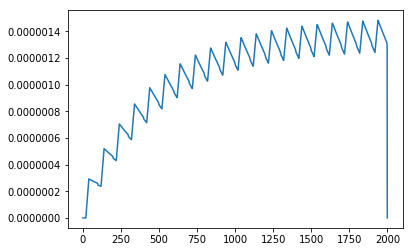

In [82]:
plt.plot(q)

In [90]:
np.seterr(over='raise')
(i,v,q)=tm.apply_2T_model(0,-2.1,time_domain,vf)

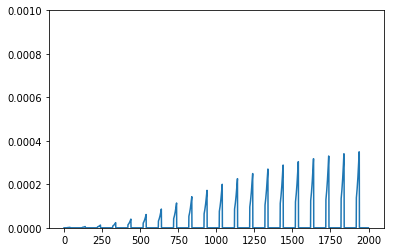

In [93]:
plt.ylim(bottom=0)
plt.ylim(top=1e-3)
plt.plot(i)

In [101]:
(i2,v2,q2)=tm.apply_2T_model(q[1998],-2.1,time_domain,vf2)

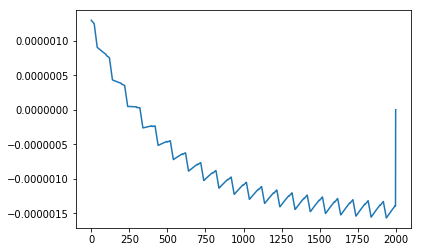

In [102]:
plt.plot(q2)

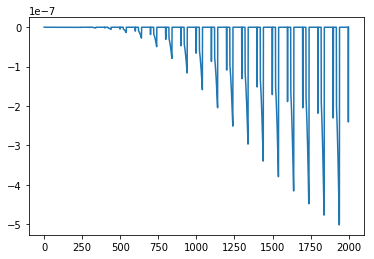

In [103]:
plt.plot(i2)

In [110]:
print(q2[-2])

-1.39544772523e-06


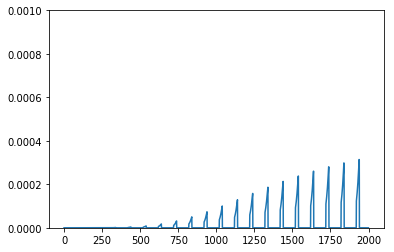

In [111]:
(i,v,q)=tm.apply_2T_model(q2[-2],-2.1,time_domain,vf)
plt.ylim(bottom=0)
plt.ylim(top=1e-3)
plt.plot(i)

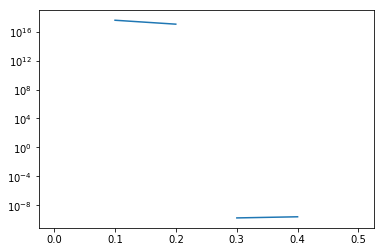

In [39]:
plt.semilogy(time_domain,abs(i))

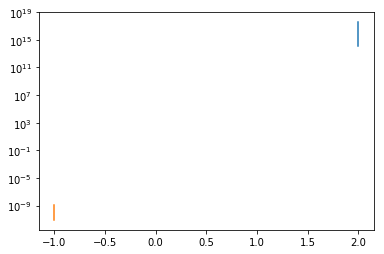

In [132]:
vup=v[0:499]
iup=i[0:499]

plt.semilogy(vup[230:270],abs(iup[230:270]))

vdn=v[500:999]
idn=i[500:999]

plt.semilogy(vdn[230:270],abs(idn[230:270]))